In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [2]:
# Load the dataset
df = pd.read_csv('diabetes.csv')

# Display the first few rows
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


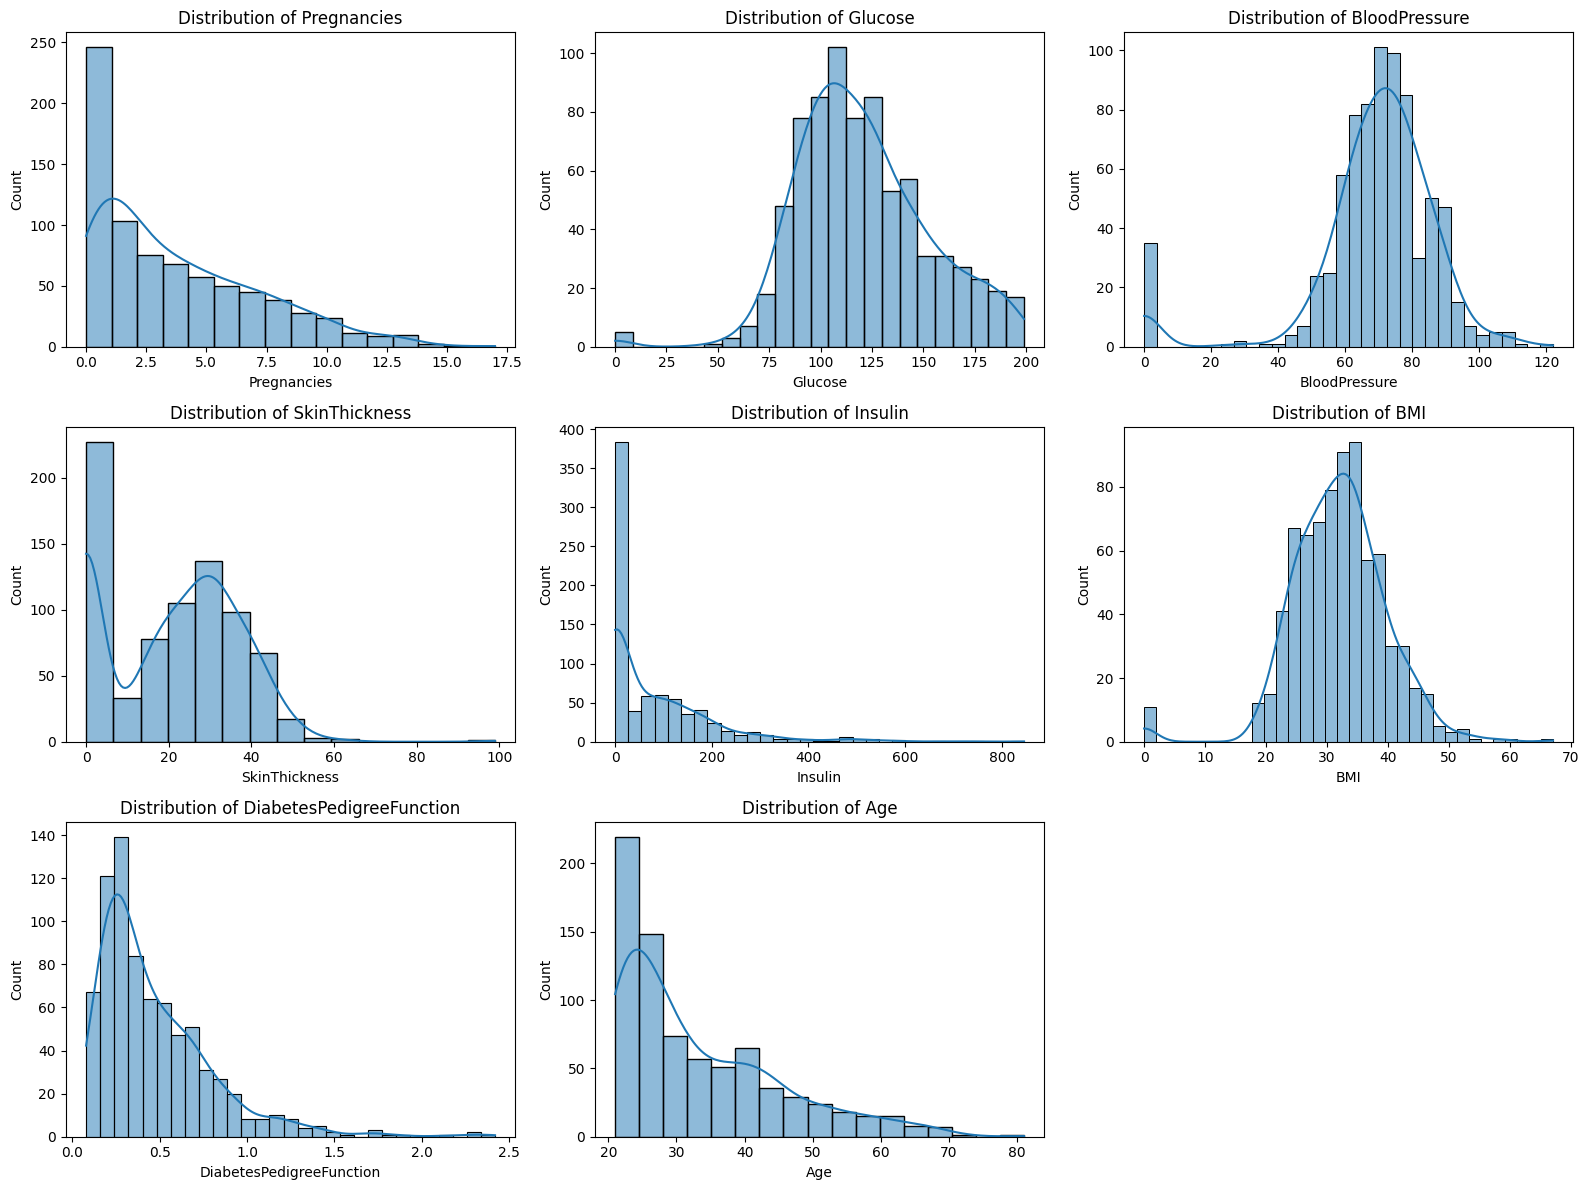

In [4]:
# Set figure size globally to avoid scrolling
plt.figure(figsize=(16, 12))

# Plot the distribution of each feature
for i, col in enumerate(df.columns[:-1], 1):
    plt.subplot(3, 3, i)  # Create subplots with 3 rows and 3 columns
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()


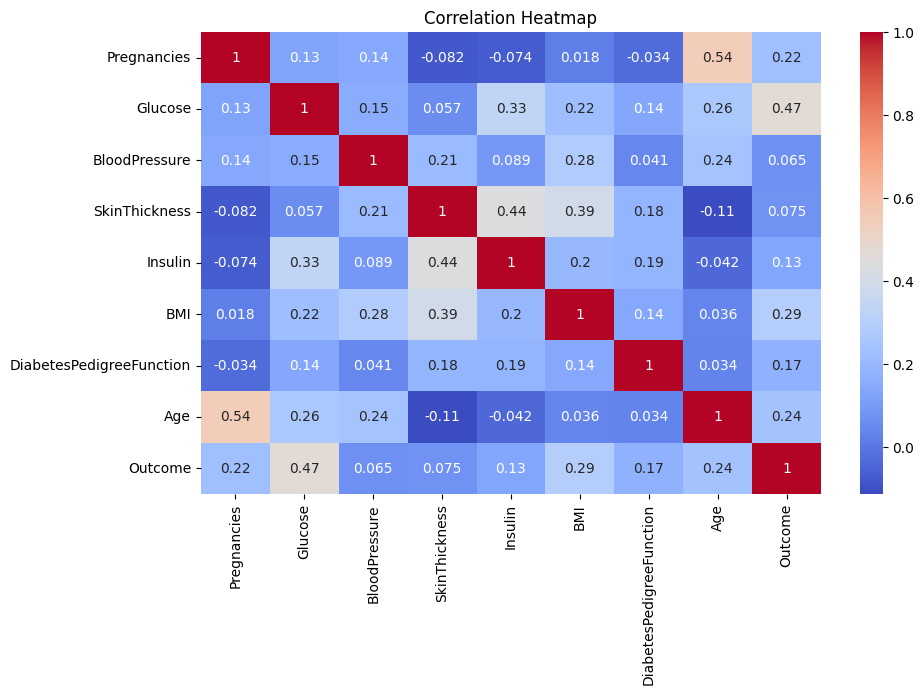

In [5]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


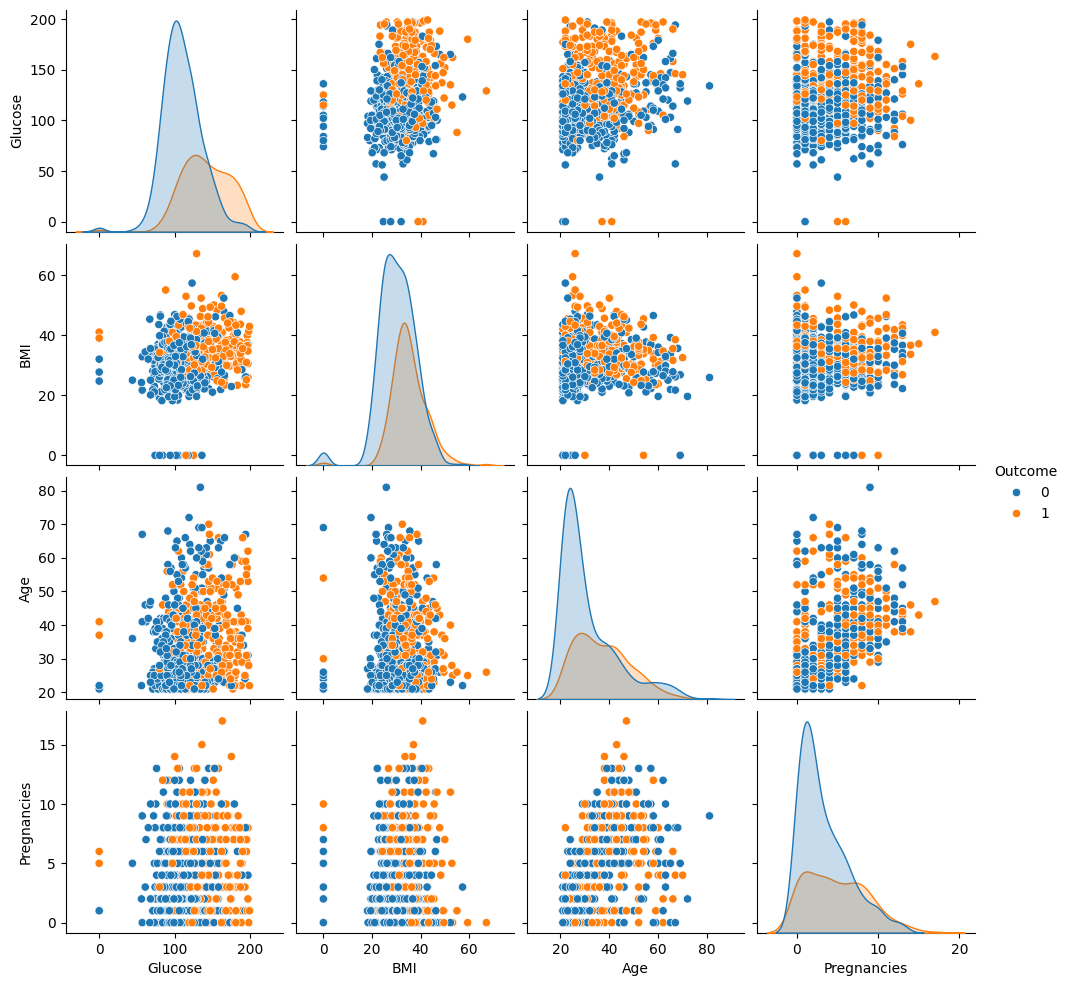

In [6]:
sns.pairplot(df[['Glucose', 'BMI', 'Age', 'Pregnancies', 'Outcome']], hue='Outcome')
plt.show()


<Figure size 1000x600 with 0 Axes>

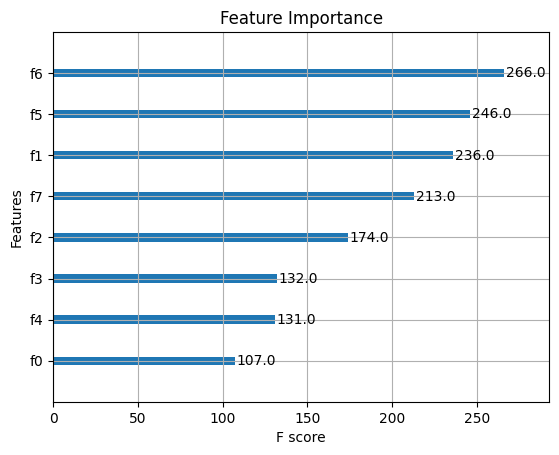

In [7]:
# Separate features and outcome
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=8)  # Show top 8 features
plt.title('Feature Importance')
plt.show()



In [8]:
# Set up the parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0]
}

# Create an XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Create the Grid Search object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best Accuracy: 0.7899373583899774


In [9]:
# Evaluate the model
y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7077922077922078
              precision    recall  f1-score   support

           0       0.79      0.74      0.76        99
           1       0.58      0.65      0.62        55

    accuracy                           0.71       154
   macro avg       0.69      0.70      0.69       154
weighted avg       0.72      0.71      0.71       154



In [10]:
# Assuming you have already defined scaler and model

def get_user_input():
    # Prompt user for inputs
    pregnancies = int(input("Enter the number of pregnancies: "))
    glucose = float(input("Enter your glucose level: "))
    blood_pressure = float(input("Enter your blood pressure: "))
    skin_thickness = float(input("Enter your skin thickness: "))
    insulin = float(input("Enter your insulin level: "))
    bmi = float(input("Enter your BMI: "))
    dpf = float(input("Enter your Diabetes Pedigree Function value: "))
    age = int(input("Enter your age: "))
    
    # Return as a list
    return [pregnancies, glucose, blood_pressure, skin_thickness, insulin, bmi, dpf, age]

def diabetes_risk_prediction():
    # Get input from user
    input_data = get_user_input()
    
    # Convert the input data into a DataFrame and scale it
    data = pd.DataFrame([input_data], columns=X.columns)  # Make sure X.columns is defined
    scaled_data = scaler.transform(data)
    
    # Make prediction using the model
    prediction = model.predict(scaled_data)[0]
    
    # Provide feedback based on prediction
    if prediction == 1:
        print("Yes, you have diabetes. Please see a doctor.")
    else:
        # Check for potential future risk
        glucose_level = input_data[1]
        bmi = input_data[5]
        if glucose_level > 140 or bmi > 30:
            print("You are healthy, but you might develop diabetes in the future. Consult a doctor.")
            future_diabetes_risk_advice(input_data)  # Call the new function for future risk advice
        else:
            print("You are healthy and have no diabetes.")

def future_diabetes_risk_advice(input_data):
    """
    Provide advice based on potential future diabetes risk.
    """
    glucose_level = input_data[1]
    bmi = input_data[5]
    age = input_data[7]

    # Provide specific advice based on user inputs
    print("\nAdvice for managing your health:")
    
    if glucose_level > 140:
        print("- Your glucose level is above the normal range. Consider reducing sugar intake and increasing physical activity.")
    
    if bmi > 30:
        print("- Your BMI indicates obesity. A balanced diet and regular exercise can help in weight management.")

    if age > 45:
        print("- At your age, regular check-ups for diabetes are advisable.")
    
    print("- Maintain a healthy lifestyle with a balanced diet, regular exercise, and routine health screenings.")

# Call the function to get user input and make predictions
diabetes_risk_prediction()


Enter the number of pregnancies: 1
Enter your glucose level: 200
Enter your blood pressure: 130
Enter your skin thickness: 1
Enter your insulin level: 168
Enter your BMI: 40
Enter your Diabetes Pedigree Function value: 44
Enter your age: 44
You are healthy, but you might develop diabetes in the future. Consult a doctor.

Advice for managing your health:
- Your glucose level is above the normal range. Consider reducing sugar intake and increasing physical activity.
- Your BMI indicates obesity. A balanced diet and regular exercise can help in weight management.
- Maintain a healthy lifestyle with a balanced diet, regular exercise, and routine health screenings.


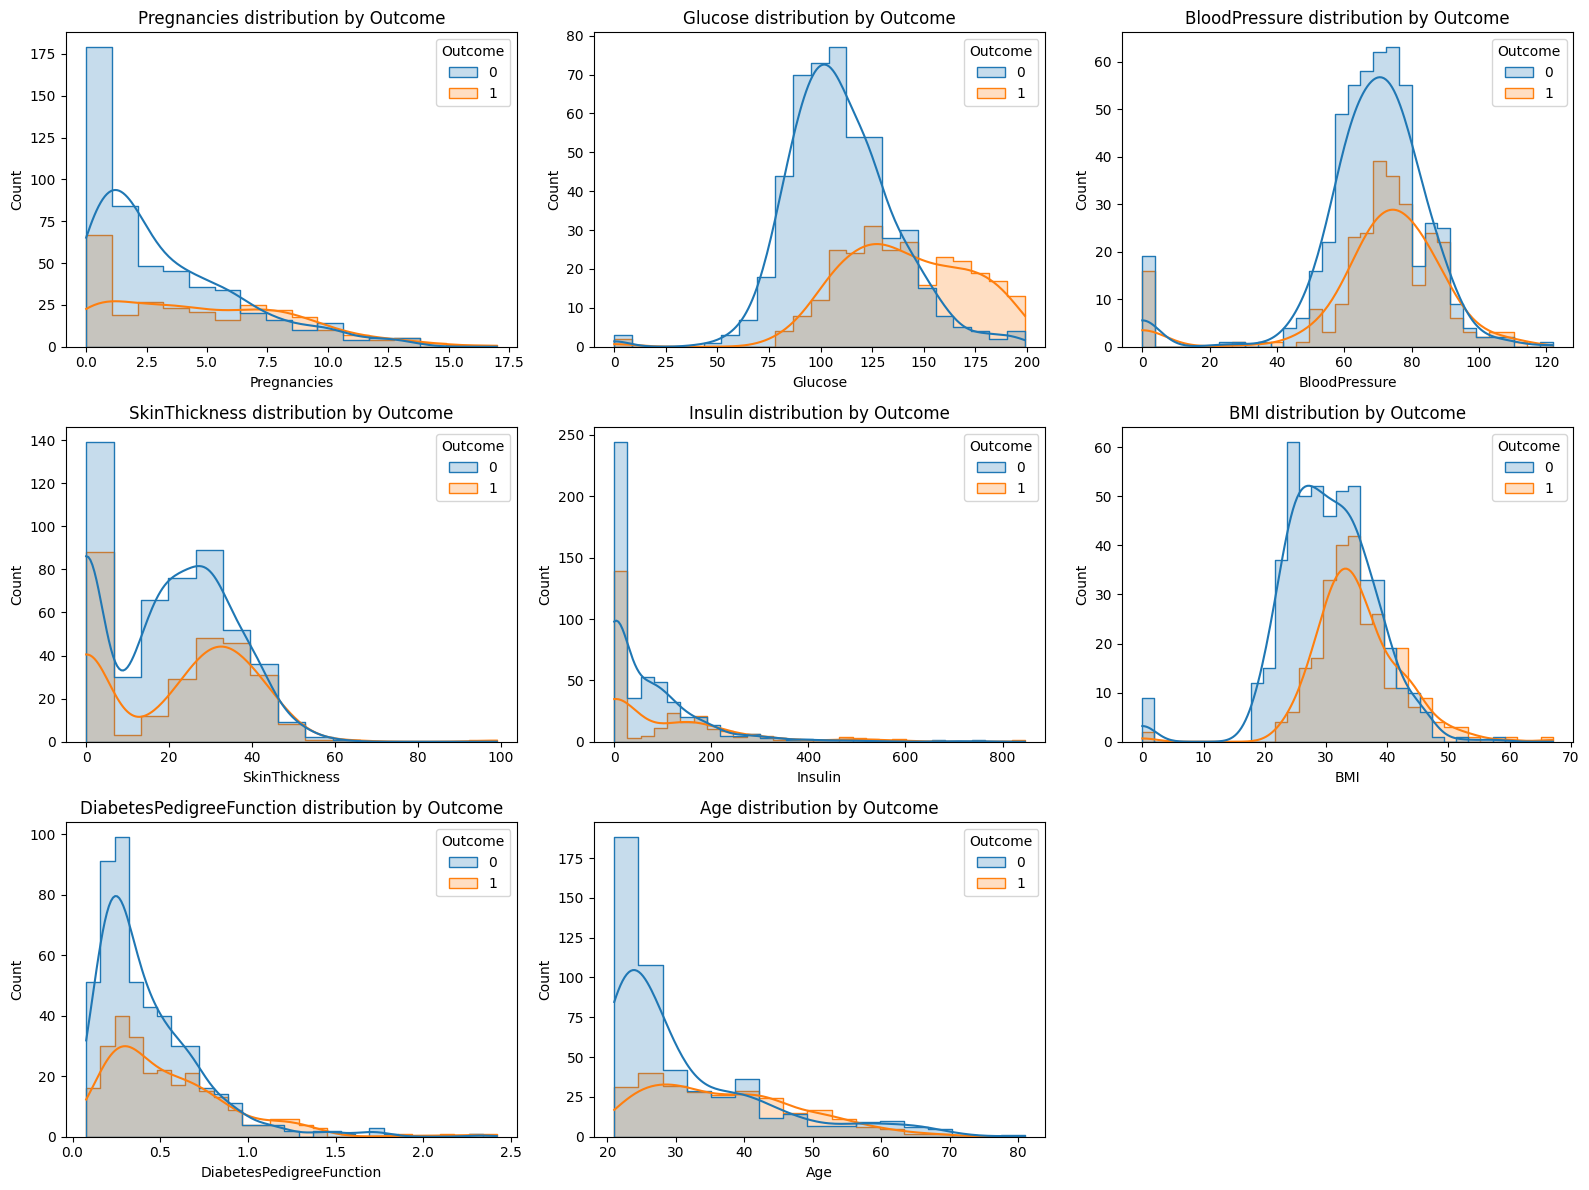

In [11]:
# Set the figure size for all plots
plt.figure(figsize=(16, 12))

# Loop through each column and create histograms for both outcomes
for i, col in enumerate(df.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.histplot(df, x=col, hue='Outcome', kde=True, element='step')
    plt.title(f'{col} distribution by Outcome')
plt.tight_layout()
plt.show()


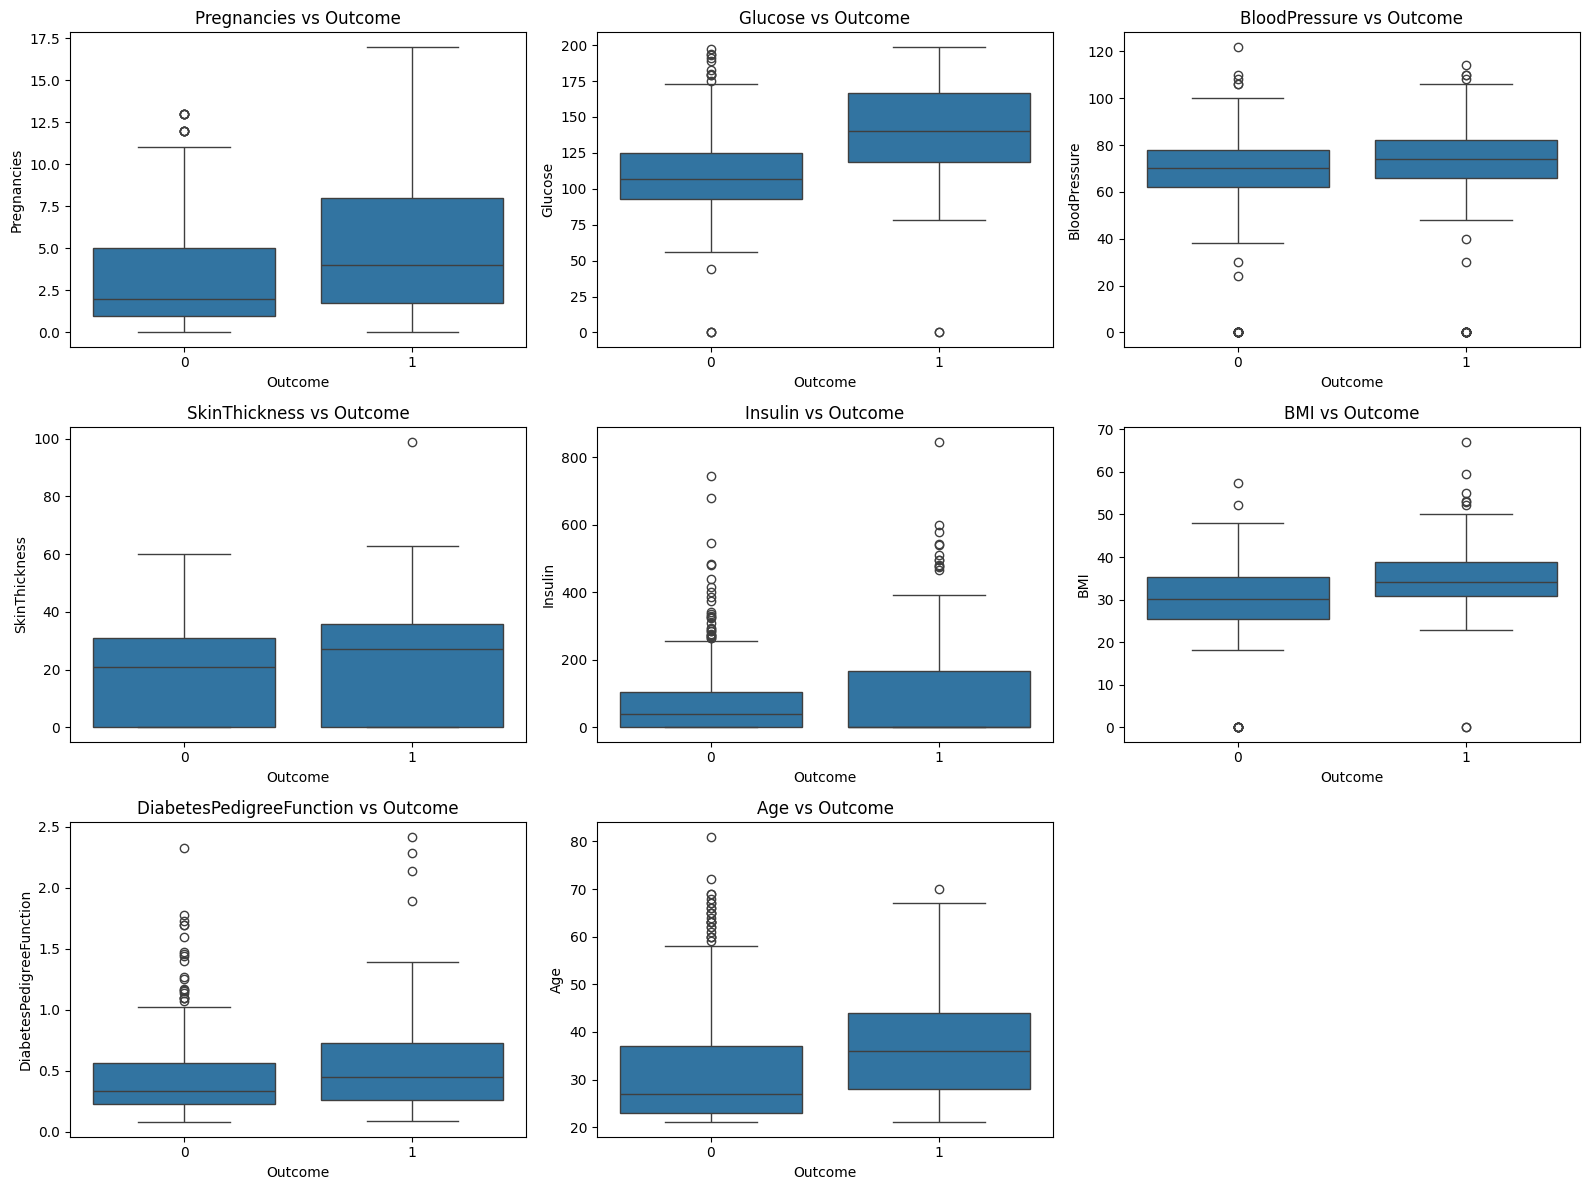

In [12]:
plt.figure(figsize=(16, 12))

# Create boxplots for each feature compared to Outcome
for i, col in enumerate(df.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='Outcome', y=col, data=df)
    plt.title(f'{col} vs Outcome')
plt.tight_layout()
plt.show()


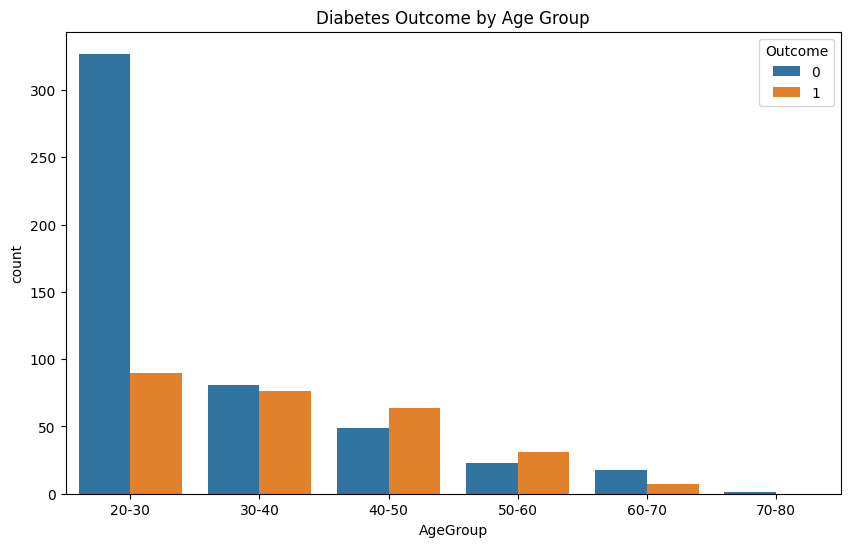

In [13]:
# Create age and BMI bins
df['AgeGroup'] = pd.cut(df['Age'], bins=[20, 30, 40, 50, 60, 70, 80], labels=['20-30', '30-40', '40-50', '50-60', '60-70', '70-80'])
df['BMICategory'] = pd.cut(df['BMI'], bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, 50], labels=['Underweight', 'Normal', 'Overweight', 'Obesity Class 1', 'Obesity Class 2', 'Obesity Class 3'])

# Bar plot showing Outcome by AgeGroup and BMI Category
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='AgeGroup', hue='Outcome')
plt.title('Diabetes Outcome by Age Group')
plt.show()


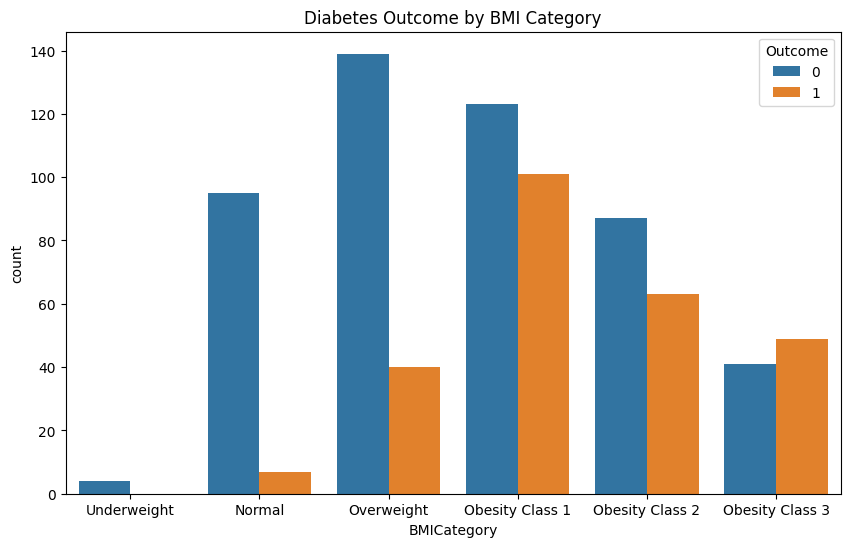

In [15]:

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='BMICategory', hue='Outcome')
plt.title('Diabetes Outcome by BMI Category')
plt.show()

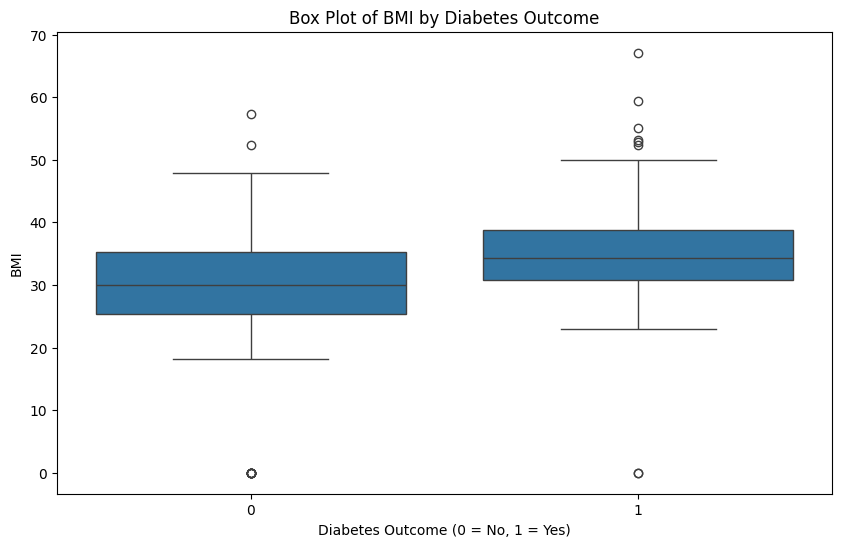

In [16]:
# Box plot for BMI by Outcome
plt.figure(figsize=(10, 6))
sns.boxplot(x='Outcome', y='BMI', data=df)
plt.title('Box Plot of BMI by Diabetes Outcome')
plt.xlabel('Diabetes Outcome (0 = No, 1 = Yes)')
plt.ylabel('BMI')
plt.show()


C:\Users\Main Profile\AppData\Local\Temp\ipykernel_26412\3690451084.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Outcome', data=df, palette='pastel')


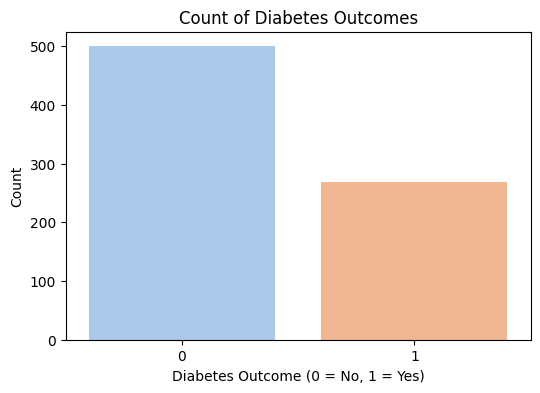

In [17]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Outcome', data=df, palette='pastel')
plt.title('Count of Diabetes Outcomes')
plt.xlabel('Diabetes Outcome (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()


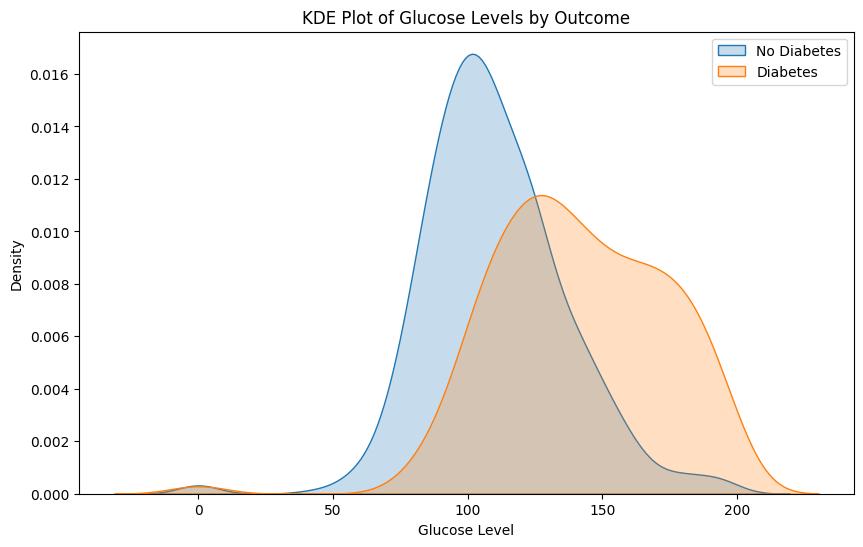

In [18]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['Outcome'] == 0]['Glucose'], label='No Diabetes', fill=True)
sns.kdeplot(df[df['Outcome'] == 1]['Glucose'], label='Diabetes', fill=True)
plt.title('KDE Plot of Glucose Levels by Outcome')
plt.xlabel('Glucose Level')
plt.ylabel('Density')
plt.legend()
plt.show()
